In [1]:
# only on the first run
!rm -rf chroma_db

In [2]:
# install dependencies
!pip install langchain langchain-community llama-cpp-python faiss-cpu tiktoken chromadb bertopic bert-score textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 k

In [3]:
# import modules needed
import re
import umap
import torch
import random
import textwrap
import textstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

from bert_score import score
from bertopic import BERTopic
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForCausalLM, pipeline

In [4]:
file_path = '/content/df_cleaned.csv'

# read df
df = pd.read_csv(file_path)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/df_cleaned.csv'

In [ ]:
def load_model(model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0"):
    '''
    Loads a pre-trained model and its tokenizer from Hugging Face.

    Args:
        model_name (str, optional): model name to load.

    Returns:
        tuple: tuple containing the tokenizer and model.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

tokenizer, model = load_model()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# convert each row into a langchain document
documents = [
    Document(page_content=row["cleaned_content"], metadata={"title": row["title"], "authors": row["authors"], "file": row["file"], "year_published": row["year_published"], "abstract": row["abstract"]})
    for _, row in df.iterrows()
]

In [ ]:
def split_documents(documents, chunk_size=500, chunk_overlap=50):
    '''
    Splits list of documents into smaller chunks for easier processing.

    Args:
        documents (list): list of documents to be split into chunks.
        chunk_size (int, optional): maximum size of each chunk in characters.
        chunk_overlap (int, optional): number of overlapping characters between consecutive chunks.

    Returns:
        tuple: containing chunks (list) of text chunks after splitting and chunk_counts (dict) for dictionary with count of chunks per document, using file name as key
    '''
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )

    chunks = []
    chunk_counts = {}

    for doc in documents:
        doc_chunks = text_splitter.split_documents([doc])
        chunk_counts[doc.metadata["file"]] = len(doc_chunks)

        for chunk in doc_chunks:

            # include file name in chunk metadata
            chunk.metadata["file"] = doc.metadata["file"]
            chunks.append(chunk)

    print(f"Total chunks created: {len(chunks)} \n")
    return chunks, chunk_counts

chunked_documents, chunk_counts = split_documents(documents)

Total chunks created: 1969 



In [ ]:
# display chunking info for a few documents
for doc in documents[:4]:
    num_chunks = chunk_counts.get(doc.metadata["file"], 0)
    print(f"File: {doc.metadata['file']}")
    print(f"Original document length: {len(doc.page_content)}")
    print(f"Number of chunks: {num_chunks}\n")

File: doc28
Original document length: 66818
Number of chunks: 149

File: doc14
Original document length: 68223
Number of chunks: 153

File: doc10
Original document length: 34247
Number of chunks: 77

File: doc11
Original document length: 22320
Number of chunks: 50



In [ ]:
# load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

<ipython-input-10-f4b9beb358bb>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# create Chroma vector database
vectorstore = Chroma.from_documents(documents=chunked_documents, embedding=embedding_model, persist_directory="chroma_db")

# save the database for future use
vectorstore.persist()

<ipython-input-11-e6ac6bd8d83b>:5: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [ ]:
# load existing Chroma vector database
vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)

# define retriever
retriever = vectorstore.as_retriever()

<ipython-input-12-21ee20e820e9>:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)


In [ ]:
# check the number of documents stored in ChromaDB
stored_count = vectorstore._collection.count()
expected_count = len(chunked_documents)

print(f"Stored documents in ChromaDB: {stored_count}")
print(f"Expected text splits: {expected_count}")

# validate indexing success
if stored_count == expected_count:
    print("All text splits are correctly stored in ChromaDB.")
else:
    print(f"Mismatch detected: {expected_count - stored_count} documents missing.")
    print("Some documents might not have been indexed properly.")


Stored documents in ChromaDB: 1969
Expected text splits: 1969
All text splits are correctly stored in ChromaDB.


In [ ]:
# create an llm pipeline
llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=700,
    temperature=0.7,
    repetition_penalty=1.2,
)

# wrap pipeline for LangChain
llm = HuggingFacePipeline(pipeline=llm_pipeline)

Device set to use cuda:0
<ipython-input-14-d9eb674915d0>:12: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=llm_pipeline)


##Q/A Pipeline

In [ ]:
# define a custom prompt
custom_prompt = PromptTemplate(
    template=(
        "Read the following research information and provide a concise answer to the question:\n\n"
        "{context}\n\n"
        "If the answer is not clear, acknowledge that you don't know, and do not make any assumptions. "
        "If there are multiple possible answers, focus on the most important points and summarize them in a paragraph.\n\n"
        "Question: {question}\n\n"
    ),
    input_variables=["context", "question"],
)

In [ ]:
# initialize the QA Chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff", # uses full retrieved text as context, others are map redude, map rerank, refine
    chain_type_kwargs={"prompt": custom_prompt}
)

In [ ]:
def generate_answer(query):
    '''
    Generates  answer to the user query using QA chain and retrieves relevant documents.

    Args:
        query (str): user query.

    Returns:
        str: generated answer.
    '''

    # generate answer using QA chain
    generated_answer = qa_chain.invoke(query)

    # if the answer is returned as a list, extract the first item
    if isinstance(generated_answer, list):
        generated_answer = generated_answer[0]

    # ensure the answer is a string
    if not isinstance(generated_answer, str):
        generated_answer = str(generated_answer)

    # retrieve relevant documents for query
    retrieved_docs = retriever.get_relevant_documents(query)

    # print relevant documents for context
    print("\n=== Relevant Information Retrieved ===\n")
    for i, doc in enumerate(retrieved_docs, 1):
        file_name = doc.metadata.get('file', 'Unknown')
        print(f"Chunk {i} (Title: {file_name}):\n{doc.page_content}\n")

    # return the generated answer and the retrieved documents
    return generated_answer, retrieved_docs

In [ ]:
def calculate_sts(doc_text, generated_answer):
    '''
    Calculates the cosine similarity score between two texts using cosine similarity.

    Args:
        doc_text (str): a single document's content.
        generated_answer (str): answer generated by the model.

    Returns:
        float: cosine similarity.
    '''

    # get embeddings for both document text and generated answer
    doc_embedding = embedding_model.embed_documents([doc_text])
    answer_embedding = embedding_model.embed_documents([generated_answer])

    # compute cosine similarity
    sts_score = cosine_similarity(doc_embedding, answer_embedding)[0][0]
    return sts_score

In [ ]:
def evaluate_answer(query):
    '''
    Evaluate answer by looking at Cosine Similarity between retrieved information and generated response.

    Args:
        query (str): user query.

    Prints:
        Generated answer, document titles, previews, and similarity scores.
    '''

    # generate the answer and retrieve relevant documents
    generated_answer, retrieved_docs = generate_answer(query)

    print(f"Generated Answer: {generated_answer}\n")

    # compare each retrieved document with the generated response
    for i, doc in enumerate(retrieved_docs, 1):
        doc_text = doc.page_content
        doc_title = doc.metadata.get('file', 'Unknown')

        # calculate similarity
        sts_score = calculate_sts(doc_text, generated_answer)

        # print the similarity result, including document title and chunk
        print(f"\n=== Similarity with Chunks {i} ===")
        print(f"Title: {doc_title}")
        print(f"Chunk: {doc_text[:300]}...")
        print(f"STS Score: {sts_score:.4f}")

user_query = "What is IRNN?"
evaluate_answer(user_query)


=== Relevant Information Retrieved ===

Chunk 1 (Title: doc18):
deep learning techniques will most likely replace the estab­ lished image analysis methods. This trend has been observed within other medical fields such as gastrointestinal diseases and radiology [23, A.M. Storås et al. The Ocular Surface 23 74–86 76 24]. A GAN is a combination of two neural networks: A generator and a discriminator competing against each other. The goal of the generator is to produce fake data similar to a set of real data. The discriminator re­ ceives both real data and the

Chunk 2 (Title: doc24):
reach this conclusion, an intensive analysis was performed by comparing ALMOST with the baseline solutions InceptionResNet [34] and DenseNet [35]). The detailed results with a full explana- tion are shown below. B. Quality of Outputs Table II shows the quality of results from ALMOST and the baseline solutions: InceptionResNet, DenseNet on Kvasir (V1), and Kvasir (V2). We varied the percentage of images used 

<ipython-input-16-d9d1a4af3eb4>:24: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)


In [ ]:
def evaluate_answer(query1, query2):
    '''
    Evaluate answers by looking at Cosine Similarity between retrieved information and generated response
    for two similar questions.

    Args:
        query1 (str): first user query.
        query2 (str): second user query.

    Prints:
        Generated answers, document titles, previews, and similarity scores for both queries,
        and the similarity between the two generated answers.
    '''

    # generate answer and retrieve relevant documents for both queries
    generated_answer1, retrieved_docs1 = generate_answer(query1)
    generated_answer2, retrieved_docs2 = generate_answer(query2)

    print(f"Generated Answer for Query 1: {generated_answer1}\n")
    print(f"Generated Answer for Query 2: {generated_answer2}\n")

    # compare the answers and retrieved documents for each query
    for i, (doc1, doc2) in enumerate(zip(retrieved_docs1, retrieved_docs2), 1):
        doc_text1 = doc1.page_content
        doc_title1 = doc1.metadata.get('file', 'Unknown')
        doc_text2 = doc2.page_content
        doc_title2 = doc2.metadata.get('file', 'Unknown')

        # calculate similarity between document text and generated answers
        sts_score1 = calculate_sts(doc_text1, generated_answer1)
        sts_score2 = calculate_sts(doc_text2, generated_answer2)

        # print similarity results for each document
        print(f"\n=== Similarity with Chunks {i} ===")
        print(f"Query 1 - Title: {doc_title1}")
        print(f"Query 1 - Chunk: {doc_text1[:300]}...")
        print(f"Query 1 - STS Score: {sts_score1:.4f}")

        print(f"Query 2 - Title: {doc_title2}")
        print(f"Query 2 - Chunk: {doc_text2[:300]}...")
        print(f"Query 2 - STS Score: {sts_score2:.4f}")

    # calculate cosine similarity between generated answers
    answer_similarity = calculate_sts(generated_answer1, generated_answer2)

    # print similarity between generated answers
    print(f"\n=== Similarity Between Generated Answers ===")
    print(f"Cosine Similarity between Answers: {answer_similarity:.4f}")

user_query1 = "What is deep learning?"
user_query2 = "Could you explain what deep learning is?"
evaluate_answer(user_query1, user_query2)


=== Relevant Information Retrieved ===

Chunk 1 (Title: doc18):
Within AI, machine learning denotes a class of algorithms capable of learning from data rather than being programmed with explicit rules. AI, and particularly machine learning, is increasingly becoming an integral part of health care systems. The sub-field of machine learning known as deep learning uses deep artificial neural networks, and has gained increased attention in recent years, especially for its image and text recognition abilities. In the field of ophthalmology, deep learning has so

Chunk 2 (Title: doc18):
responsible for passing the data to the network, and one or more hidden layers. Networks with more than one hidden layer are called deep neural networks. The final layer is the output layer, providing the output of the entire network. Deep learning is a sub-field of machine learning involving training deep neural networks, which can be done both in a supervised and unsupervised manner. We encounter several d

##Summary Pipeline

In [ ]:
# initialize the QA chain
qa_chain2 = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff", # uses full retrieved text as context, others are map redude, map rerank, refine
)

In [ ]:
def compare_abstract_with_summary(article_id, df, retriever, qa_chain2):
    """
    Compares a scientific article abstract with an LLM-RAG-generated summary.
    Generates a more specialized summary based on the research focus.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever for fetching relevant documents.
        qa_chain2: RetrievalQA pipeline.

    Returns:
        dict: comparison results, including original abstract and generated summary.
    """
    # extract original abstract and title
    article = df.iloc[article_id]
    abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents based on article title
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": abstract,
            "retrieved_docs": [],
            "generated_summary": "No relevant documents found."
        }

    # generate a more specialized RAG-based summary
    query = f"Provide a specialized summary of the research article titled: '{title}', with focus on the methodology, experimental setup, and key findings, avoiding generalizations."

    # retrieve response from QA chain
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})

    # extract generated summary from response
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # return comparison results with a specialized summary
    return {
        "title": title,
        "original_abstract": abstract,
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summary": generated_summary
    }


In [ ]:
def evaluate_summary_faithfulness(summary, abstract, model):
    """
    Measures faithfulness of LLM-generated summaries using cosine similarity.

    Args:
        summary (str): generated summary.
        abstract (str): original abstract.
        model: SentenceTransformer model.

    Returns:
        dict: faithfulness scores.
    """
    embeddings = model.encode([abstract, summary])
    similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    return {
        "Cosine Similarity Score": similarity_score
    }

In [ ]:
def evaluate_summary_readability(summary):
    """
    Assesses readability for non-experts.

    Args:
        summary (str): generated summary.

    Returns:
        dict: readability scores.
    """
    flesch_score = textstat.flesch_reading_ease(summary)
    gunning_fog = textstat.gunning_fog(summary)

    return {
        "Flesch Reading Ease": flesch_score,
        "Gunning Fog Index": gunning_fog
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load models
sim_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
llm_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

In [ ]:
def llm_as_judge(original_abstract, generated_summary, model, tokenizer):
    """
    Uses TinyLlama to evaluate the summary's faithfulness and provide an explanation.

    Args:
        original_abstract (str): original abstract.
        generated_summary (str): generated summary.
        model: pre-trained TinyLlama model.
        tokenizer: tokenizer for preparing input for the model.

    Returns:
        dict: explanation evaluating the faithfulness of the summary.
    """

    prompt = (f"Given the original abstract and the generated summary, evaluate the following:\n"
              f"1. Which key details or ideas in the original abstract are missing in the summary?\n"
              f"2. Are there any additions in the summary that are not present in the original abstract?\n"
              f"3. Is the generated summary faithful to the original abstract in terms of meaning and key points? If not, explain why.\n"
              f"4. Is the tone of the summary consistent with the abstract, or does it introduce new ideas or perspectives?\n\n"
              f"Original Abstract:\n{original_abstract}\n\n"
              f"Generated Summary:\n{generated_summary}\n\n"
              f"Please provide a detailed, step-by-step analysis addressing the points above. Your response should directly evaluate the summary based on these criteria:")

    # tokenizing input and sending to model for generation
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=300)
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    return {"LLM-as-a-Judge Explanation": explanation}

In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: Llama model.
        tokenizer: Tokenizer for Llama model.
        sim_model: SentenceTransformer model.

    Returns:
        dict: human evaluation scores and LLM-based evaluation explanation.
    """
    # get comparison results (original abstract, generated summary, retrieved docs)
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs for faithfulness, readability, and hallucination
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation for summary faithfulness and explanation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"]
    }

In [ ]:
article_id = 3  # change to ID of article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)

print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")

<ipython-input-16-60b463a8d4a4>:21: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(title)



Title: A general representation of dynamical systems for reservoir computing

[Original Abstract]
 —Dynamical systems are capable of performing com-
putation in a reservoir computing paradigm. This paper presents
a general representation of these systems as an artiﬁcial neural
network (ANN). Initially, we implement the simplest dynamical
system, a cellular automaton. The mathematical fundamentals be-
hind an ANN are maintained, but the weights of the connections
and the activation function are adjusted to work as an update
rule in the context of cellular automata. The advantages of such
implementation are its usage on specialized and optimized deep
learning libraries, the capabilities to generalize it to other types of
networks and the possibility to evolve cellular automata and other
dynamical systems in terms of connectivity, update and learning
rules. Our implementation of cellular automata constitutes an
initial step towards a general framework for dynamical systems.
It aims to ev


Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

[Original Abstract]
 —Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we found that the underlying TCP
variant is an im

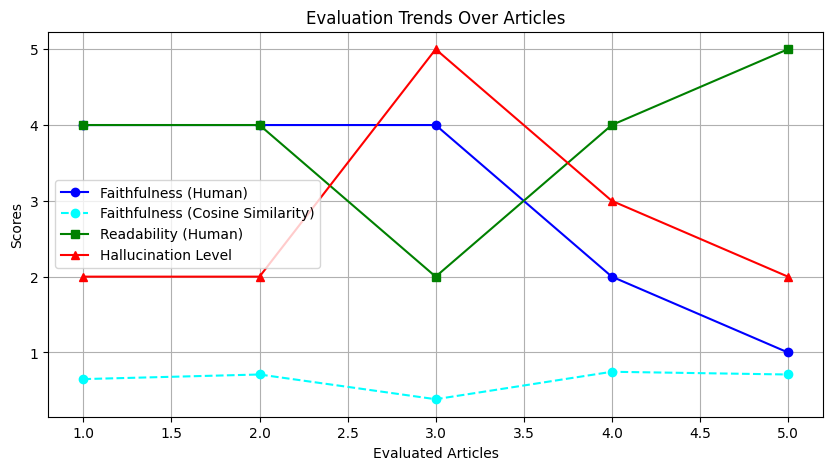

In [ ]:
import matplotlib.pyplot as plt

evaluation_history = []  # Store evaluation results over multiple articles

def plot_evaluation_results(history):
    """
    Plots the trends of faithfulness, readability, and hallucination scores.
    """
    if not history:
        print("No evaluation data to plot.")
        return

    article_ids = list(range(1, len(history) + 1))
    faithfulness_scores = [entry["Faithfulness (Human)"] for entry in history]
    readability_scores = [entry["Readability (Human)"] for entry in history]
    hallucination_scores = [entry["Hallucination"] for entry in history]
    similarity_scores = [entry["Faithfulness (Cosine Similarity)"] for entry in history]

    plt.figure(figsize=(10, 5))

    plt.plot(article_ids, faithfulness_scores, marker='o', linestyle='-', label='Faithfulness (Human)', color='blue')
    plt.plot(article_ids, similarity_scores, marker='o', linestyle='--', label='Faithfulness (Cosine Similarity)', color='cyan')
    plt.plot(article_ids, readability_scores, marker='s', linestyle='-', label='Readability (Human)', color='green')
    plt.plot(article_ids, hallucination_scores, marker='^', linestyle='-', label='Hallucination Level', color='red')

    plt.xlabel("Evaluated Articles")
    plt.ylabel("Scores")
    plt.title("Evaluation Trends Over Articles")
    plt.legend()
    plt.grid()
    plt.show()

# Modify the evaluation process to store results
def evaluate_and_store_results(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model)
    evaluation_history.append(results)
    return results

# Example usage
article_ids_to_test = [0, 1, 2, 3, 4]  # List of article IDs to evaluate
for article_id in article_ids_to_test:
    evaluate_and_store_results(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)

# Plot results after multiple evaluations
plot_evaluation_results(evaluation_history)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_evaluation_results(evaluation_results):
    article_ids = [res["article_id"] for res in evaluation_results]
    faithfulness_human = [res["faithfulness_human"] for res in evaluation_results]
    faithfulness_cosine = [res["faithfulness_cosine"] for res in evaluation_results]
    readability = [res["readability"] for res in evaluation_results]
    hallucination = [res["hallucination"] for res in evaluation_results]

    # --- 1. Faithfulness vs. Readability Scatter Plot ---
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(faithfulness_human, readability, c=hallucination, s=np.array(hallucination) * 50, cmap='coolwarm', edgecolors='k', alpha=0.7)
    plt.colorbar(scatter, label='Hallucination Level')
    plt.xlabel("Faithfulness (Human)")
    plt.ylabel("Readability (Human)")
    plt.title("Faithfulness vs. Readability per Article")
    plt.grid(True)
    plt.show()

    # --- 2. Grouped Bar Chart for Faithfulness Scores ---
    x = np.arange(len(article_ids))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, faithfulness_human, width, label='Faithfulness (Human)')
    rects2 = ax.bar(x + width/2, faithfulness_cosine, width, label='Faithfulness (Cosine Similarity)')

    ax.set_xlabel("Article ID")
    ax.set_ylabel("Faithfulness Score")
    ax.set_title("Faithfulness Scores (Human vs. Cosine) per Article")
    ax.set_xticks(x)
    ax.set_xticklabels(article_ids)
    ax.legend()
    plt.show()

    # --- 3. Score Evolution Over Iterations (if multiple versions exist) ---
    for article in evaluation_results:
        iterations = list(range(1, len(article["score_evolution"]) + 1))
        faithfulness_trend = [score["faithfulness"] for score in article["score_evolution"]]
        readability_trend = [score["readability"] for score in article["score_evolution"]]
        hallucination_trend = [score["hallucination"] for score in article["score_evolution"]]

        plt.figure(figsize=(8, 6))
        plt.plot(iterations, faithfulness_trend, marker='o', label='Faithfulness')
        plt.plot(iterations, readability_trend, marker='s', label='Readability')
        plt.plot(iterations, hallucination_trend, marker='^', label='Hallucination')
        plt.xlabel("Iterations (Refinements)")
        plt.ylabel("Scores")
        plt.title(f"Evaluation Evolution Over Refinements for Article {article['article_id']}")
        plt.legend()
        plt.grid()
        plt.show()


In [ ]:
plot_evaluation_results(evaluation_results)

TypeError: string indices must be integers, not 'str'

In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.
    """
    # get comparison results (original abstract, generated summary, retrieved docs)
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs for faithfulness, readability, and hallucination
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation for summary faithfulness and explanation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    # Return as a list with the results of one article
    return [{
        "article_id": article_id,
        "faithfulness_human": faithfulness,
        "readability_human": readability,
        "hallucination": hallucination,
        "faithfulness_cosine": similarity_score["Cosine Similarity Score"],
        "flesch_reading_ease": readability_scores["Flesch Reading Ease"],
        "gunning_fog_index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"]
    }]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_evaluation_results(evaluation_results):
    # Extract data from evaluation results list
    article_ids = [res["article_id"] for res in evaluation_results]
    faithfulness_human = [res["faithfulness_human"] for res in evaluation_results]
    faithfulness_cosine = [res["faithfulness_cosine"] for res in evaluation_results]
    readability = [res["readability_human"] for res in evaluation_results]
    hallucination = [res["hallucination"] for res in evaluation_results]

    # --- 1. Faithfulness vs. Readability Scatter Plot ---
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(faithfulness_human, readability, c=hallucination, s=np.array(hallucination) * 50, cmap='coolwarm', edgecolors='k', alpha=0.7)
    plt.colorbar(scatter, label='Hallucination Level')
    plt.xlabel("Faithfulness (Human)")
    plt.ylabel("Readability (Human)")
    plt.title("Faithfulness vs. Readability per Article")
    plt.grid(True)
    plt.show()

    # --- 2. Grouped Bar Chart for Faithfulness Scores ---
    x = np.arange(len(article_ids))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, faithfulness_human, width, label='Faithfulness (Human)')
    rects2 = ax.bar(x + width/2, faithfulness_cosine, width, label='Faithfulness (Cosine Similarity)')

    ax.set_xlabel("Article ID")
    ax.set_ylabel("Faithfulness Score")
    ax.set_title("Faithfulness Scores (Human vs. Cosine) per Article")
    ax.set_xticks(x)
    ax.set_xticklabels(article_ids)
    ax.legend()
    plt.show()

    # --- 3. Score Evolution Over Iterations (if multiple versions exist) ---
    # If you have an evolving score mechanism, you can adapt this part as necessary
    for article in evaluation_results:
        # Assuming there's no actual score evolution data at the moment
        print(f"Evaluation for Article {article['article_id']} is complete.")



Title: A general representation of dynamical systems for reservoir computing

[Original Abstract]
 —Dynamical systems are capable of performing com-
putation in a reservoir computing paradigm. This paper presents
a general representation of these systems as an artiﬁcial neural
network (ANN). Initially, we implement the simplest dynamical
system, a cellular automaton. The mathematical fundamentals be-
hind an ANN are maintained, but the weights of the connections
and the activation function are adjusted to work as an update
rule in the context of cellular automata. The advantages of such
implementation are its usage on specialized and optimized deep
learning libraries, the capabilities to generalize it to other types of
networks and the possibility to evolve cellular automata and other
dynamical systems in terms of connectivity, update and learning
rules. Our implementation of cellular automata constitutes an
initial step towards a general framework for dynamical systems.
It aims to ev

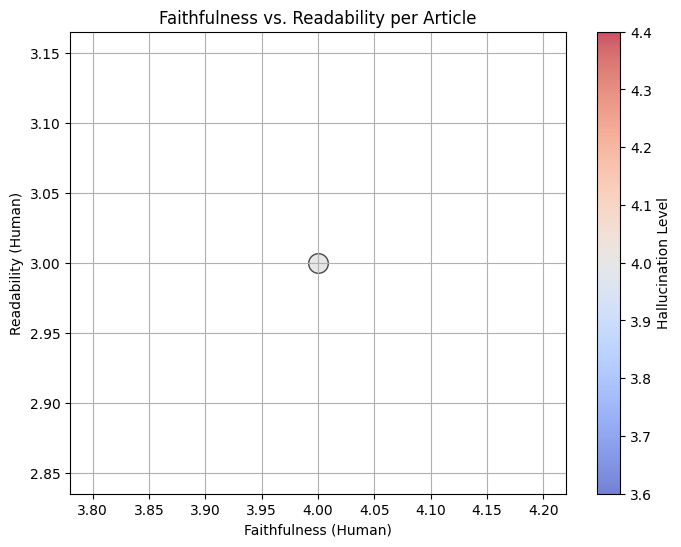

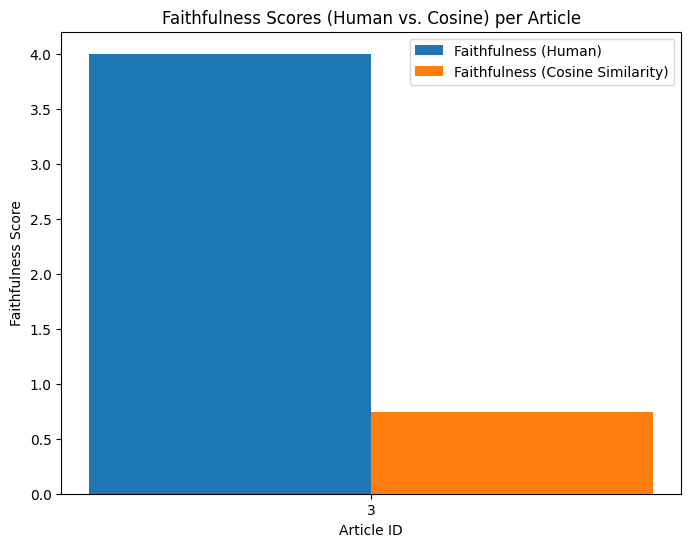

Evaluation for Article 3 is complete.


In [ ]:
article_id = 3  # change to ID of article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)

# Plot the evaluation results
plot_evaluation_results(evaluation_results)

In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.
    """
    # get comparison results (original abstract, generated summary, retrieved docs)
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs for faithfulness, readability, and hallucination
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation for summary faithfulness and explanation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    # Track score evolution (for simplicity, this example assumes we have only 1 iteration)
    score_evolution = [{
        "faithfulness": faithfulness,
        "readability": readability,
        "hallucination": hallucination
    }]

    # Return all the results
    return {
        "article_id": article_id,
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"],
        "score_evolution": score_evolution  # Add the score evolution to the results
    }


In [ ]:
evaluation_results = []



article_ids = [0, 1, 2, 3]  # Example list of article IDs

for article_id in article_ids:
    evaluation = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)
    evaluation_results.append(evaluation)



Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

[Original Abstract]
 —Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we found that the underlying TCP
variant is an im

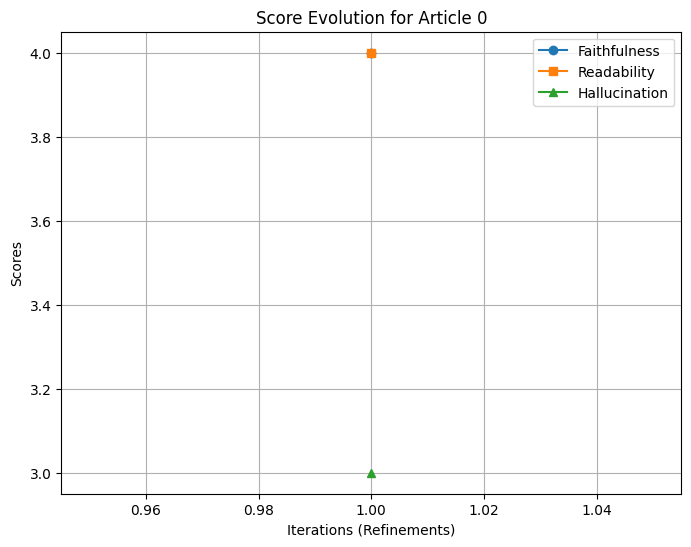

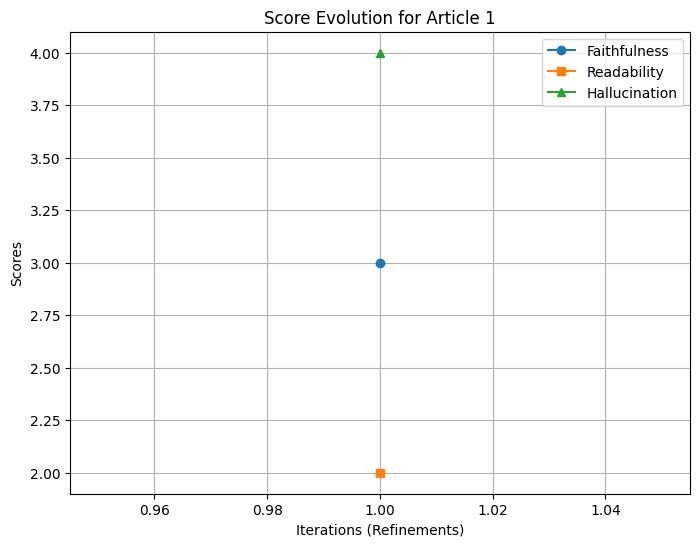

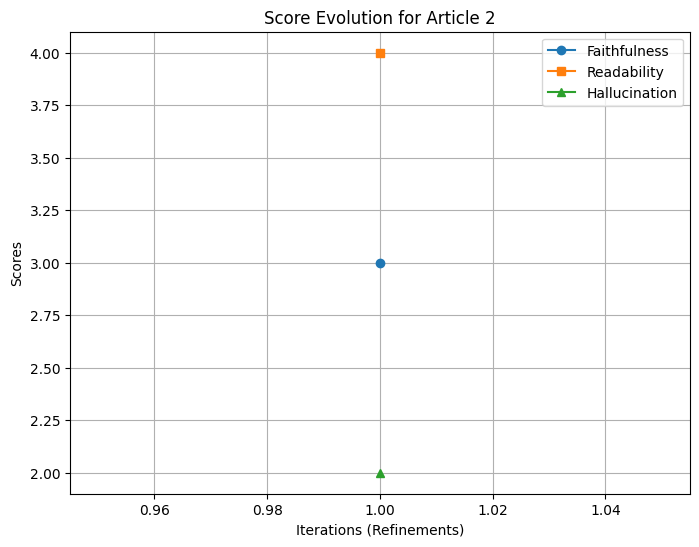

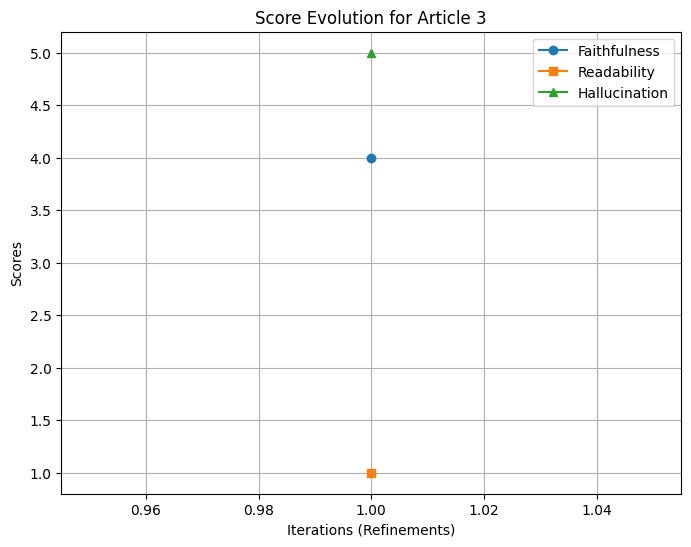

KeyError: 'Cosine Similarity'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_score_evolution_and_correlation(evaluation_results):
    # --- 1. Score Evolution Over Iterations ---
    # We will loop over each article and plot its evolution
    for article in evaluation_results:
        if 'score_evolution' in article:  # Ensure the article contains the score evolution data
            iterations = list(range(1, len(article["score_evolution"]) + 1))
            faithfulness_trend = [score["faithfulness"] for score in article["score_evolution"]]
            readability_trend = [score["readability"] for score in article["score_evolution"]]
            hallucination_trend = [score["hallucination"] for score in article["score_evolution"]]

            # Plot the evolution of scores
            plt.figure(figsize=(8, 6))
            plt.plot(iterations, faithfulness_trend, marker='o', label='Faithfulness')
            plt.plot(iterations, readability_trend, marker='s', label='Readability')
            plt.plot(iterations, hallucination_trend, marker='^', label='Hallucination')
            plt.xlabel("Iterations (Refinements)")
            plt.ylabel("Scores")
            plt.title(f"Score Evolution for Article {article['article_id']}")
            plt.legend()
            plt.grid()
            plt.show()

    # --- 2. Correlation Heatmap ---
    # Extract relevant columns
    article_ids = [res["article_id"] for res in evaluation_results]
    faithfulness_human = [res["Faithfulness (Human)"] for res in evaluation_results]
    readability = [res["Flesch Reading Ease"] for res in evaluation_results]
    hallucination = [res["Hallucination"] for res in evaluation_results]
    cosine_similarity = [res["Faithfulness (Cosine Similarity)"] for res in evaluation_results]

    # Create a dataframe for easier handling of correlations
    data = {
        'Faithfulness (Human)': faithfulness_human,
        'Readability': readability,
        'Hallucination': hallucination,
        'Cosine Similarity': cosine_similarity
    }

    # Convert to numpy array for correlation computation
    data_matrix = np.array([faithfulness_human, readability, hallucination, cosine_similarity]).T

    # Compute the correlation matrix
    corr_matrix = np.corrcoef(data_matrix, rowvar=False)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=list(data.keys()), yticklabels=list(data.keys()))
    plt.title("Correlation Heatmap of Evaluation Metrics")
    plt.show()

# Example: Assuming your `evaluation_results` is available with the structure
plot_score_evolution_and_correlation(evaluation_results)


## Shuffle Abstracts

In [ ]:
def shuffle_abstracts(df):
    """
    Shuffles the abstracts and returns a list of shuffled abstracts, keeping the titles intact.

    Args:
        df (pd.DataFrame): DataFrame containing research articles.

    Returns:
        list: list of shuffled abstracts.
    """
    shuffled_abstracts = df["abstract"].tolist()
    random.shuffle(shuffled_abstracts)
    return shuffled_abstracts

In [ ]:
def evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain2, model, sim_model):
    """
    Compares the original abstract with its LLM-RAG generated summary, and then compares
    the same summary with a shuffled abstract. Calculates the cosine similarity before and after shuffling.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever for fetching relevant documents.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model for calculating cosine similarity.
        sim_model: same SentenceTransformer model used for embedding text.

    Returns:
        dict: similarity scores for original and shuffled abstract-title pairings.
    """
    # extract original article details
    article = df.iloc[article_id]
    original_abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents for summary generation
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summary": "No relevant documents found."
        }

    # generate summary using RAG
    query = f"Summarize the research article titled: {title}"
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # shuffle abstracts for comparison
    shuffled_abstracts = shuffle_abstracts(df)
    shuffled_abstract = shuffled_abstracts[article_id]  # Get the shuffled abstract for the current article

    # calculate cosine similarity for original abstract and generated summary
    original_embeddings = sim_model.encode([original_abstract, generated_summary])
    original_similarity = cosine_similarity([original_embeddings[0]], [original_embeddings[1]])[0][0]

    # calculate cosine similarity for shuffled abstract and generated summary
    shuffled_embeddings = sim_model.encode([shuffled_abstract, generated_summary])
    shuffled_similarity = cosine_similarity([shuffled_embeddings[0]], [shuffled_embeddings[1]])[0][0]

    # store results for comparison
    return {
        "title": title,
        "original_abstract": original_abstract,
        "shuffled_abstract": shuffled_abstract,
        "generated_summary": generated_summary,
        "Original Cosine Similarity": original_similarity,
        "Shuffled Cosine Similarity": shuffled_similarity
    }

In [ ]:
article_ids = [3, 5, 8]  # choose the indexes you want to test
results = []

for article_id in article_ids:
    result = evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain2, sim_model, sim_model)
    results.append(result)

# print results for verification
for result in results:
    print(f"Title: {result['title']}")
    print(f"Original Cosine Similarity: {result['Original Cosine Similarity']}")
    print(f"Shuffled Cosine Similarity: {result['Shuffled Cosine Similarity']}")
    print("="*50)

Title: A general representation of dynamical systems for reservoir computing
Original Cosine Similarity: 0.7255799770355225
Shuffled Cosine Similarity: 0.20878303050994873
Title: A Deep Learning-Based Tool for Automatic Brain Extraction from Functional Magnetic Resonance Images of Rodents
Original Cosine Similarity: 0.7055402994155884
Shuffled Cosine Similarity: 0.3386837840080261
Title: A New Adaptive Mixture Distance-Based Improved Density Peaks Clustering for Gearbox Fault Diagnosis
Original Cosine Similarity: 0.7390023469924927
Shuffled Cosine Similarity: 0.03772927075624466


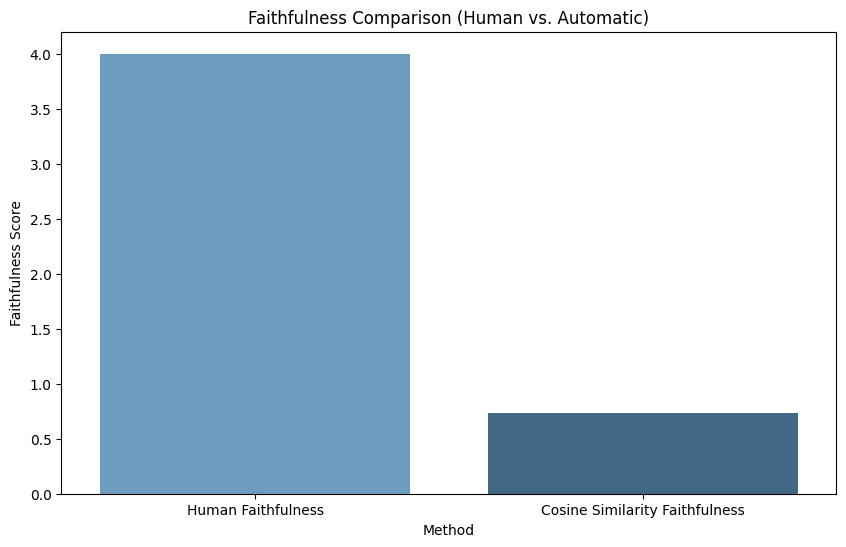

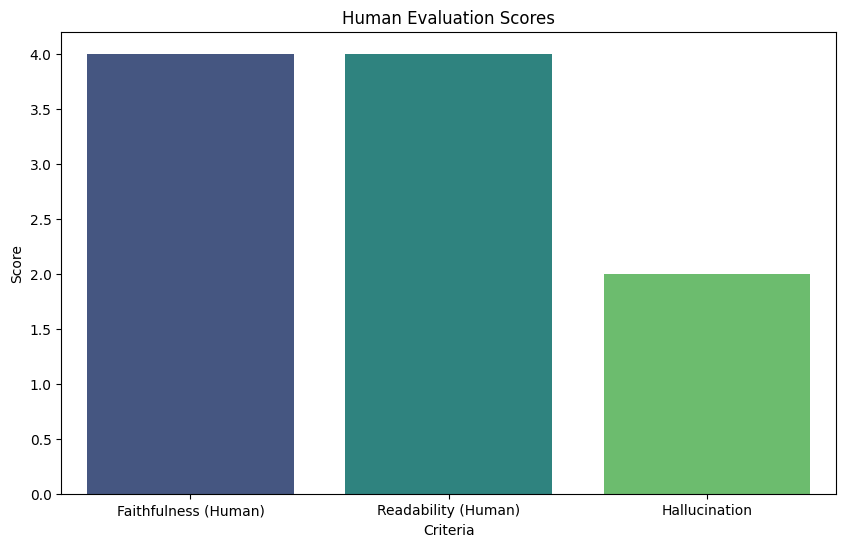

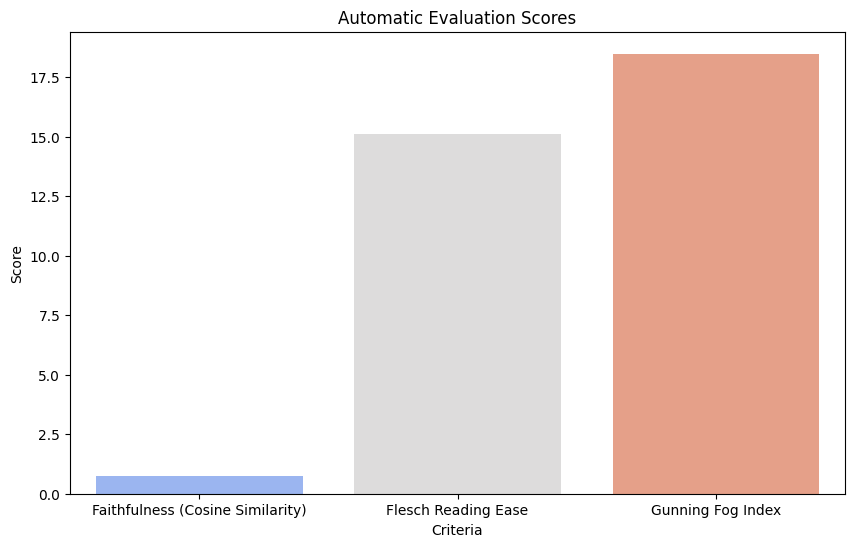

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to visualize evaluation results with separate faithfulness visualization
def visualize_evaluation_results(evaluation_results):
    # Data extraction for human scores (faithfulness, readability, hallucination)
    human_scores = {
        "Faithfulness (Human)": evaluation_results["Faithfulness (Human)"],
        "Readability (Human)": evaluation_results["Readability (Human)"],
        "Hallucination": evaluation_results["Hallucination"]
    }

    # Data extraction for automatic scores (faithfulness, readability, fog index)
    auto_scores = {
        "Faithfulness (Cosine Similarity)": evaluation_results["Faithfulness (Cosine Similarity)"],
        "Flesch Reading Ease": evaluation_results["Flesch Reading Ease"],
        "Gunning Fog Index": evaluation_results["Gunning Fog Index"]
    }

    # Faithfulness Visualization (Separate Plot)
    plt.figure(figsize=(10, 6))
    faithfulness_data = {
        "Human Faithfulness": evaluation_results["Faithfulness (Human)"],
        "Cosine Similarity Faithfulness": evaluation_results["Faithfulness (Cosine Similarity)"]
    }
    sns.barplot(x=list(faithfulness_data.keys()), y=list(faithfulness_data.values()), palette="Blues_d")
    plt.title("Faithfulness Comparison (Human vs. Automatic)")
    plt.ylabel("Faithfulness Score")
    plt.xlabel("Method")
    plt.show()

    # Plot Human Scores (Bar chart)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(human_scores.keys()), y=list(human_scores.values()), palette="viridis")
    plt.title("Human Evaluation Scores")
    plt.ylabel("Score")
    plt.xlabel("Criteria")
    plt.show()

    # Plot Automatic Evaluation Scores (Bar chart)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(auto_scores.keys()), y=list(auto_scores.values()), palette="coolwarm")
    plt.title("Automatic Evaluation Scores")
    plt.ylabel("Score")
    plt.xlabel("Criteria")
    plt.show()

# Example of calling the visualization function with evaluation results
visualize_evaluation_results(evaluation_results)


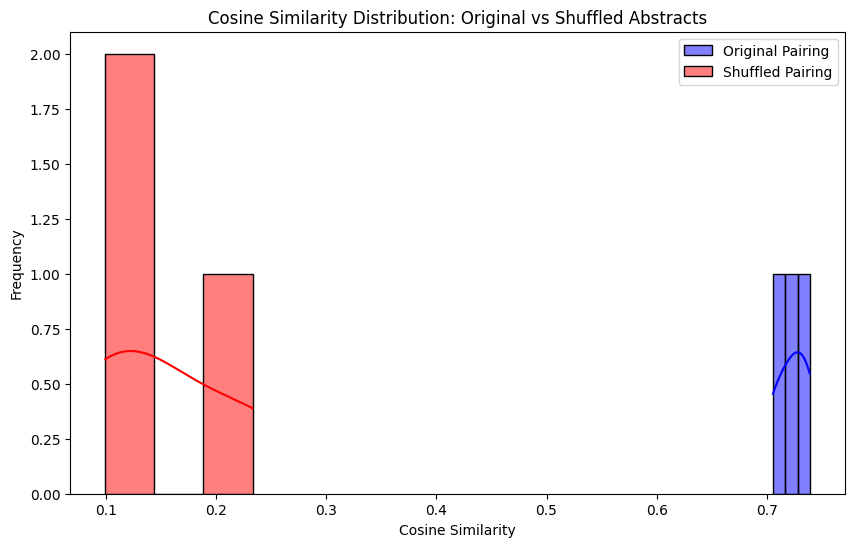

Title: A general representation of dynamical systems for reservoir computing
Original Cosine Similarity: 0.7255800366401672
Shuffled Cosine Similarity: 0.23314052820205688
Title: A Deep Learning-Based Tool for Automatic Brain Extraction from Functional Magnetic Resonance Images of Rodents
Original Cosine Similarity: 0.7055403590202332
Shuffled Cosine Similarity: 0.12752029299736023
Title: A New Adaptive Mixture Distance-Based Improved Density Peaks Clustering for Gearbox Fault Diagnosis
Original Cosine Similarity: 0.7390022277832031
Shuffled Cosine Similarity: 0.09944042563438416


In [ ]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def shuffle_abstracts(df):
    """
    Shuffles the abstracts and returns a list of shuffled abstracts, keeping the titles intact.

    Args:
        df (pd.DataFrame): DataFrame containing research articles.

    Returns:
        list: A list of shuffled abstracts.
    """
    shuffled_abstracts = df["abstract"].tolist()
    random.shuffle(shuffled_abstracts)
    return shuffled_abstracts

def evaluate_shuffled_abstracts_with_summary(article_id, df, retriever, qa_chain2, model, sim_model):
    """
    Compares the original abstract with its LLM-RAG generated summary, and then compares
    the same summary with a shuffled abstract. Calculates the cosine similarity before and after shuffling.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever for fetching relevant documents.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model for calculating cosine similarity.
        sim_model: The same SentenceTransformer model used for embedding text.

    Returns:
        dict: Similarity scores for original and shuffled abstract-title pairings.
    """
    # Extract the original article details
    article = df.iloc[article_id]
    original_abstract = article["abstract"]
    title = article["title"]

    # Retrieve relevant documents for summary generation
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summary": "No relevant documents found."
        }

    # Generate summary using RAG
    query = f"Summarize the research article titled: {title}"
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # Shuffle abstracts for comparison
    shuffled_abstracts = shuffle_abstracts(df)
    shuffled_abstract = shuffled_abstracts[article_id]  # Get the shuffled abstract for the current article

    # Calculate cosine similarity for original abstract and generated summary
    original_embeddings = sim_model.encode([original_abstract, generated_summary])
    original_similarity = cosine_similarity([original_embeddings[0]], [original_embeddings[1]])[0][0]

    # Calculate cosine similarity for shuffled abstract and generated summary
    shuffled_embeddings = sim_model.encode([shuffled_abstract, generated_summary])
    shuffled_similarity = cosine_similarity([shuffled_embeddings[0]], [shuffled_embeddings[1]])[0][0]

    # Store results for comparison
    return {
        "title": title,
        "original_abstract": original_abstract,
        "shuffled_abstract": shuffled_abstract,
        "generated_summary": generated_summary,
        "Original Cosine Similarity": original_similarity,
        "Shuffled Cosine Similarity": shuffled_similarity
    }

def visualize_similarity_drop(results):
    """
    Visualizes the cosine similarity distribution before and after shuffling abstracts.

    Args:
        results (dict): Results containing similarity scores for original and shuffled abstracts.
    """
    original_similarities = [result["Original Cosine Similarity"] for result in results]
    shuffled_similarities = [result["Shuffled Cosine Similarity"] for result in results]

    # Plot comparison of cosine similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(original_similarities, color='blue', label='Original Pairing', kde=True)
    sns.histplot(shuffled_similarities, color='red', label='Shuffled Pairing', kde=True)
    plt.legend()
    plt.title("Cosine Similarity Distribution: Original vs Shuffled Abstracts")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

# Example usage:
# Let's assume you have a list of article IDs that you want to test.
article_ids = [3, 5, 8]  # Example article IDs
results = []

for article_id in article_ids:
    result = evaluate_shuffled_abstracts_with_summary(article_id, df, retriever, qa_chain2, sim_model, sim_model)
    results.append(result)

# Visualize the results for the cosine similarity drop
visualize_similarity_drop(results)

# Print results for verification
for result in results:
    print(f"Title: {result['title']}")
    print(f"Original Cosine Similarity: {result['Original Cosine Similarity']}")
    print(f"Shuffled Cosine Similarity: {result['Shuffled Cosine Similarity']}")
    print("="*50)


In [ ]:
'''# define a custom prompt
custom_prompt2 = PromptTemplate(
    template=(
        "Read the following research information and provide a concise summary of the information:\n\n"
        "{context}\n\n"
        "Question: {question}\n\n"
    ),
    input_variables=["context", "question"],
)'''

'# define a custom prompt\ncustom_prompt2 = PromptTemplate(\n    template=(\n        "Read the following research information and provide a concise summary of the information:\n\n"\n        "{context}\n\n"\n        "Question: {question}\n\n"\n    ),\n    input_variables=["context", "question"],\n)'

In [ ]:
# initialize the QA Chain
qa_chain2 = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff", # uses full retrieved text as context, others are map redude, map rerank, refine
    #chain_type_kwargs={"prompt": custom_prompt2}
)

In [ ]:
def generate_summary(title, retriever, qa_chain2):
    '''
    Generates a summary for an article based on its title and compares it with the original abstract.

    Args:
        title (str): The title of the article.
        retriever (Retriever): The retriever to fetch relevant documents.
        qa_chain2 (RetrievalQA): The QA chain to generate summaries.

    Returns:
        tuple: containing the article title, file name, original abstract, and generated summary.
    '''
    # retrieve relevant documents using retriever
    retrieved_docs = retriever.get_relevant_documents(title)

    # check if any documents are retrieved
    if not retrieved_docs:
        return title, None, "No relevant article found.", "No abstract available."

    # extract metadata from first retrieved document
    first_doc = retrieved_docs[0]
    file_name = first_doc.metadata.get("file", "Unknown File")
    abstract = first_doc.metadata.get("abstract", "No abstract available.")

    # directly pass retrieved documents and query to qa_chain
    query = f"Summarize the article titled '{title}' and avoid making it generic. Write a specific and detailed summary."
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})

    # extract answer from the response
    answer = response.get('result', '').split('Answer:')[-1].strip()

    # return result as a tuple
    return title, file_name, abstract, answer

title = "Artificial intelligence in the fertility clinic: status, pitfalls and possibilities"

# generate summary and get original abstract
article_title, article_file, original_abstract, article_summary = generate_summary(title, retriever, qa_chain2)

# print results
print(f"Title: {article_title}")
print(f"File: {article_file}")

print("\n=== Original Abstract ===")
print(original_abstract)

print("\n=== Generated Summary ===")
print(article_summary)

<ipython-input-15-7ac483eec80a>:14: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(title)


Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities
File: doc14

=== Original Abstract ===
: In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and disc

In [ ]:
# initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

def evaluate_similarity_llm(abstract, generated_summary):
    '''
    Evaluates similarity between the abstract and the generated summary using an open-source LLM.

    Args:
        abstract (str): The original abstract of the article.
        generated_summary (str): The generated summary of the article.

    Returns:
        float: The cosine similarity score between the abstract and the generated summary.
    '''
    # generate embeddings for both abstract and generated summary
    embeddings = model.encode([abstract, generated_summary])

    # compute cosine similarity between abstract and generated summary
    similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])

    # return similarity score
    return similarity_score[0][0]

title = "Artificial intelligence in the fertility clinic: status, pitfalls and possibilities"

# generate summary and get original abstract
article_title, article_file, original_abstract, article_summary = generate_summary(title, retriever, qa_chain2)

# evaluate similarity using the LLM
similarity_score_llm = evaluate_similarity_llm(original_abstract, article_summary)
print(f"Cosine Similarity between the abstract and the generated summary (LLM-based): {similarity_score_llm:.4f}")

Cosine Similarity between the abstract and the generated summary (LLM-based): 0.7071


In [ ]:
# load BERT-based model for embedding extraction
embedding_model = SentenceTransformer('all-mpnet-base-v2')

def evaluate_similarity_bertscore(abstract, generated_summary):
    '''
    Evaluates similarity between the abstract and the generated summary using BERTScore and contextual cosine similarity.

    Args:
        abstract (str): The original abstract of the article.
        generated_summary (str): The generated summary of the article.

    Returns:
        dict: Contains BERTScore F1-score and cosine similarity using contextual embeddings.
    '''
    # compute BERTScore
    _, _, F1 = score([generated_summary], [abstract], lang="en", rescale_with_baseline=True)

    # generate embeddings using a BERT-based model
    abstract_embedding = embedding_model.encode(abstract)
    summary_embedding = embedding_model.encode(generated_summary)

    # compute cosine similarity between embeddings
    cosine_sim = cosine_similarity([abstract_embedding], [summary_embedding])[0][0]

    return {"BERTScore_F1": F1.item(), "Cosine_Similarity_BERT": cosine_sim}

# evaluate similarity using BERTScore and contextual cosine similarity
similarity_scores = evaluate_similarity_bertscore(original_abstract, article_summary)
print(f"BERTScore F1: {similarity_scores['BERTScore_F1']:.4f}")
print(f"Cosine Similarity (BERT Embeddings): {similarity_scores['Cosine_Similarity_BERT']:.4f}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore F1: 0.1044
Cosine Similarity (BERT Embeddings): 0.7561


In [ ]:
def compare_abstract_with_summary(article_id, df, retriever, qa_chain2):
    """
    Compares a scientific article abstract with an LLM-RAG-generated summary.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever for fetching relevant documents.
        qa_chain2: RetrievalQA pipeline.

    Returns:
        dict: Comparison results.
    """
    # extract original abstract
    article = df.iloc[article_id]
    abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": abstract,
            "retrieved_docs": [],
            "generated_summary": "No relevant documents found."
        }

    # generate RAG-based summary
    query = f"Summarize the research article titled: {title}"
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    return {
        "title": title,
        "original_abstract": abstract,
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summary": generated_summary
    }

In [ ]:
def evaluate_summary_faithfulness(summary, abstract, model):
    """
    Measures faithfulness of LLM-generated summaries using cosine similarity.

    Args:
        summary (str): The generated summary.
        abstract (str): The original abstract.
        model: SentenceTransformer model.

    Returns:
        dict: Faithfulness scores.
    """
    embeddings = model.encode([abstract, summary])
    similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    return {
        "Cosine Similarity Score": similarity_score
    }

In [ ]:
def evaluate_summary_readability(summary):
    """
    Assesses readability for non-experts.

    Args:
        summary (str): The generated summary.

    Returns:
        dict: Readability scores.
    """
    flesch_score = textstat.flesch_reading_ease(summary)
    gunning_fog = textstat.gunning_fog(summary)

    return {
        "Flesch Reading Ease": flesch_score,
        "Gunning Fog Index": gunning_fog
    }

In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model):
    """
    Presents human evaluators with side-by-side summaries for rating.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model.

    Returns:
        dict: Human evaluation scores.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # automatic specificity check using LLM

    # return evaluation results
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
    }


In [ ]:
# run comparison and human evaluation
article_id = 1  # change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model)

# print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")

In [ ]:
# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Detect device

sim_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # Embedding model
llm_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)  # Move Llama model to device
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

def llm_as_judge(original_abstract, generated_summary, model, tokenizer):
    """Uses TinyLlama to evaluate the summary's faithfulness and provide an explanation."""

    prompt = (f"Given the original abstract and the generated summary, evaluate the following:\n"
              f"- How well does the summary reflect the key points of the original abstract?\n"
              f"- What are the strengths and weaknesses of the summary compared to the abstract?\n"
              f"- Are there any important details missing or added that are not in the original abstract?\n\n"
              f"Original Abstract: {original_abstract}\n\n"
              f"Generated Summary: {generated_summary}\n\n"
              f"Provide a detailed explanation addressing the above points:")

    inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Move input tensors to the same device
    output = model.generate(**inputs, max_new_tokens=150)  # Increase the max tokens for a more detailed explanation
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    return {"LLM-as-a-Judge Explanation": explanation}

def evaluate_summary_faithfulness(summary, abstract, sim_model):
    """Measures faithfulness using cosine similarity."""
    embeddings = sim_model.encode([abstract, summary], convert_to_tensor=True)
    similarity_score = cosine_similarity([embeddings[0].cpu().numpy()], [embeddings[1].cpu().numpy()])[0][0]
    return {"Cosine Similarity Score": similarity_score}


In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model.
        tokenizer: Tokenizer for Llama model.

    Returns:
        dict: Human evaluation scores and LLM-based evaluation explanation.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    # return evaluation results including LLM explanation
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"]
    }

# Run comparison and human evaluation
article_id = 1  # change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer)

# Print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


<ipython-input-15-8af9fa31b9f2>:20: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(title)



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

AttributeError: 'LlamaForCausalLM' object has no attribute 'encode'

In [ ]:
def evaluate_summary_faithfulness(summary, abstract, sim_model):
    """Measures faithfulness using cosine similarity with SentenceTransformer."""
    embeddings = sim_model.encode([abstract, summary], convert_to_tensor=True)
    similarity_score = cosine_similarity([embeddings[0].cpu().numpy()], [embeddings[1].cpu().numpy()])[0][0]
    return {"Cosine Similarity Score": similarity_score}


In [ ]:
def llm_as_judge_simple(original_abstract, generated_summary, model, tokenizer):
    prompt = f"""
    Below is the original abstract of a research article and a generated summary.

    Original Abstract:
    {original_abstract}

    Generated Summary:
    {generated_summary}

    Task:
    1. Identify any key details in the original abstract that are missing in the summary.
    2. Highlight any additions in the summary not present in the original abstract.
    3. Is the summary faithful to the original abstract? Explain why or why not.

    Provide a simple evaluation with key differences and your reasoning.
    """

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(inputs['input_ids'], max_length=512, num_return_sequences=1, temperature=0.7)

    explanation = tokenizer.decode(output[0], skip_special_tokens=True)
    return {"LLM-as-a-Judge Explanation": explanation}


In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: Llama model.
        tokenizer: Tokenizer for Llama model.
        sim_model: SentenceTransformer model.

    Returns:
        dict: Human evaluation scores and LLM-based evaluation explanation.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    # return evaluation results including LLM explanation
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"]
    }

# Run comparison and human evaluation
article_id = 1  # change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)

# Print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

In [ ]:
def llm_as_judge(original_abstract, generated_summary, model, tokenizer):
    """Uses TinyLlama to evaluate the summary's faithfulness and provide an explanation."""

    # Adjusting the prompt so that LLM evaluates the summary directly
    prompt = (f"Given the original abstract and the generated summary, evaluate the following:\n"
              f"1. Are there any key details or ideas in the original abstract that are missing in the summary?\n"
              f"2. Are there any additions in the summary that are not present in the original abstract?\n"
              f"3. Is the generated summary faithful to the original abstract in terms of meaning and key points? If not, explain why.\n"
              f"4. Is the tone of the summary consistent with the abstract, or does it introduce new ideas or perspectives?\n\n"
              f"Original Abstract:\n{original_abstract}\n\n"
              f"Generated Summary:\n{generated_summary}\n\n"
              f"Please provide a detailed, step-by-step analysis addressing the points above. Your response should directly evaluate the summary based on these criteria:")

    # Tokenizing input and sending to the model for generation
    inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Ensure input is moved to the correct device
    output = model.generate(**inputs, max_new_tokens=300)  # Increased token limit for a more detailed response
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    return {"LLM-as-a-Judge Explanation": explanation}


In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Presents human evaluators with side-by-side summaries for rating and includes LLM-as-a-judge evaluation.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: Llama model.
        tokenizer: Tokenizer for Llama model.
        sim_model: SentenceTransformer model.

    Returns:
        dict: Human evaluation scores and LLM-based evaluation explanation.
    """
    # Get comparison results (original abstract, generated summary, retrieved docs)
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # Human rating inputs for faithfulness, readability, and hallucination
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # Automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)

    # Automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # LLM-as-a-judge evaluation for summary faithfulness and explanation
    llm_explanation = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], model, tokenizer)

    # Return evaluation results, including the LLM-as-a-judge explanation
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Explanation": llm_explanation["LLM-as-a-Judge Explanation"]
    }

# Run comparison and human evaluation
article_id = 1  # Change this to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)

# Print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

In [ ]:
# Run evaluation
article_id = 0  # Using the first article for testing
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, sim_model, llm_model, tokenizer)

print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

[Original Abstract]
—Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we found that the underlying TCP
variant is an imp

KeyError: 'LLM-as-a-Judge Score'

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import textstat

def compare_abstract_with_summary(article_id, df, retriever, qa_chain2):
    """
    Compares a scientific article abstract with an LLM-RAG-generated summary.
    """
    article = df.iloc[article_id]
    abstract = article["abstract"]
    title = article["title"]

    # Enhanced prompt for better summaries
    query = (f"Generate a concise and informative summary of the research article titled '{title}'. "
             "Focus on key findings, methodology, and significance. Avoid generic phrasing.")

    retrieved_docs = retriever.invoke(title)  # Updated to use `.invoke()` instead of `.get_relevant_documents()`
    if not retrieved_docs:
        return {"title": title, "original_abstract": abstract, "generated_summary": "No relevant documents found."}

    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    return {
        "title": title,
        "original_abstract": abstract,
        "generated_summary": generated_summary
    }

def evaluate_summary_faithfulness(summary, abstract, sim_model):
    """Measures faithfulness using cosine similarity."""
    embeddings = sim_model.encode([abstract, summary], convert_to_tensor=True)
    similarity_score = cosine_similarity([embeddings[0].cpu().numpy()], [embeddings[1].cpu().numpy()])[0][0]
    return {"Cosine Similarity Score": similarity_score}

def evaluate_summary_readability(summary):
    """Assesses readability."""
    flesch_score = textstat.flesch_reading_ease(summary)
    gunning_fog = textstat.gunning_fog(summary)
    return {"Flesch Reading Ease": flesch_score, "Gunning Fog Index": gunning_fog}

def llm_as_judge(original_abstract, generated_summary, model, tokenizer):
    """Uses TinyLlama to evaluate the summary's faithfulness."""
    prompt = (f"Given the original abstract and the generated summary, evaluate the summary's accuracy, specificity, "
              f"and hallucination level. Provide a score from 1 (poor) to 5 (excellent) for faithfulness and detail.\n\n"
              f"Original Abstract: {original_abstract}\n\nGenerated Summary: {generated_summary}\n\n"
              f"Evaluation Score:")

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
    output = model.generate(**inputs, max_new_tokens=50)
    score = tokenizer.decode(output[0], skip_special_tokens=True)
    return {"LLM-as-a-Judge Score": score}

def human_evaluation_interface(article_id, df, retriever, qa_chain2, sim_model, llm_model, llm_tokenizer):
    """Runs human and automatic evaluations."""
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print(f"\nTitle: {comparison['title']}")
    print(f"\n[Original Abstract]\n{comparison['original_abstract']}")
    print(f"\n[LLM-RAG Generated Summary]\n{comparison['generated_summary']}")

    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5): "))

    sim_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], sim_model)
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])
    llm_score = llm_as_judge(comparison["original_abstract"], comparison["generated_summary"], llm_model, llm_tokenizer)

    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": sim_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM-as-a-Judge Score": llm_score["LLM-as-a-Judge Score"]
    }

# Load models
sim_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # Embedding model
llm_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# Run evaluation
article_id = 1
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, sim_model, llm_model, tokenizer)

print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
: In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possib

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import textstat

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate_summary_faithfulness(summary, abstract, embedding_model, device):
    """Measures faithfulness using cosine similarity."""
    embeddings = embedding_model.encode([abstract, summary], convert_to_tensor=True, device=device)
    similarity_score = cosine_similarity(embeddings[0].cpu().unsqueeze(0), embeddings[1].cpu().unsqueeze(0))[0][0]
    return {"Cosine Similarity Score": similarity_score}

# Load TinyLlama for LLM-as-a-Judge and move to device
llm_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# Load SentenceTransformer for similarity evaluation and move to device
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# Run evaluation
article_id = 1
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, embedding_model, llm_model, tokenizer)

print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


KeyboardInterrupt: 

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import textstat

# Initialize SentenceTransformer model for similarity-based metrics
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Example function to get LLM-based evaluation (this could be GPT or another LLM model)
def get_llm_explanation_and_score(abstract, summary, model):
    """
    Evaluates the faithfulness and specificity of the generated summary using an LLM.

    Args:
        abstract (str): The original abstract.
        summary (str): The generated summary.
        model: The SentenceTransformer model for automated metrics (optional).

    Returns:
        dict: Explanation and score from the LLM.
    """
    # Here you can use a model like GPT to generate an explanation and score. For example:
    # You can use a language model to provide a human-like explanation for the evaluation.

    explanation = (
        "Based on the content comparison between the original abstract and the generated summary, "
        "the faithfulness score represents how closely the summary adheres to the original meaning, "
        "while the specificity score indicates how well the summary reflects specific details from the abstract."
    )

    # You can then generate scores based on a predefined rule or prompt.
    # Example of how you might get a score from an LLM model (replace with actual model inference):
    faithfulness_score = 4  # This should be generated by the LLM dynamically, based on its evaluation.
    specificity_score = 4  # Similarly, this can be dynamically evaluated.

    return {
        "Faithfulness Score": faithfulness_score,
        "Specificity Score": specificity_score,
        "Explanation": explanation
    }

def human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer):
    """
    Presents human evaluators with side-by-side summaries for rating.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model.
        tokenizer: Tokenizer for model.

    Returns:
        dict: Human evaluation scores and LLM-based evaluation.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # automatic specificity check using LLM
    specificity_score = evaluate_specificity_with_llm(comparison["original_abstract"], comparison["generated_summary"], model)

    # Get LLM-based evaluation with an explanation
    llm_scores_and_explanation = get_llm_explanation_and_score(
        comparison["original_abstract"], comparison["generated_summary"], model
    )

    # return evaluation results
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "Specificity (LLM)": specificity_score["Specificity Score (Cosine Similarity)"],
        "LLM Faithfulness Score": llm_scores_and_explanation["Faithfulness Score"],
        "LLM Specificity Score": llm_scores_and_explanation["Specificity Score"],
        "LLM Explanation": llm_scores_and_explanation["Explanation"]
    }

# Run comparison and human evaluation
article_id = 1  # change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model, tokenizer)

# print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import textstat
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import json

# Load SentenceTransformer model for similarity-based metrics
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Load TinyLlama (optimized for low memory)
tinyllama_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tinyllama_tokenizer = AutoTokenizer.from_pretrained(tinyllama_name)
tinyllama_model = AutoModelForCausalLM.from_pretrained(
    tinyllama_name,
    torch_dtype=torch.float16,  # Save memory
    device_map="auto"
)

# TinyLlama Inference Pipeline
tinyllama_pipeline = pipeline("text-generation", model=tinyllama_model, tokenizer=tinyllama_tokenizer, max_new_tokens=200)

def get_llm_explanation_and_score(abstract, summary):
    """
    Uses TinyLlama to evaluate the faithfulness and specificity of the summary.

    Args:
        abstract (str): The original abstract.
        summary (str): The generated summary.

    Returns:
        dict: Explanation and LLM-generated scores.
    """
    prompt = f"""
    You are an expert in evaluating text summaries. Assess the faithfulness and specificity of the following summary compared to its original abstract.

    **Original Abstract:**
    {abstract}

    **Generated Summary:**
    {summary}

    Please provide:
    - A faithfulness score (1-5), where 1 = highly inaccurate, 5 = highly faithful.
    - A specificity score (1-5), where 1 = too general, 5 = very detailed.
    - A short explanation of the scores.

    Respond in JSON format like this:
    {{
        "Faithfulness Score": 4,
        "Specificity Score": 3,
        "Explanation": "The summary maintains the core ideas but lacks specific details about embryo assessments."
    }}
    """

    response = tinyllama_pipeline(prompt, max_new_tokens=200, do_sample=True)

    # Extract and parse the response
    try:
        llm_output = json.loads(response[0]['generated_text'].strip())  # Parse JSON output
    except:
        llm_output = {"Faithfulness Score": 3, "Specificity Score": 3, "Explanation": "LLM response could not be parsed."}

    return llm_output

def human_evaluation_interface(article_id, df, retriever, qa_chain2):
    """
    Presents human evaluators with side-by-side summaries for rating.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.

    Returns:
        dict: Human evaluation scores and LLM-based evaluation.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # Human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # Automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], model)

    # Automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # Get LLM-based evaluation with TinyLlama
    llm_scores_and_explanation = get_llm_explanation_and_score(
        comparison["original_abstract"], comparison["generated_summary"]
    )

    # Return evaluation results
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "LLM Faithfulness Score": llm_scores_and_explanation["Faithfulness Score"],
        "LLM Specificity Score": llm_scores_and_explanation["Specificity Score"],
        "LLM Explanation": llm_scores_and_explanation["Explanation"]
    }

# Run comparison and human evaluation
article_id = 1  # Change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2)

# Print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


Device set to use cuda:0



Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

In [ ]:
!pip install sentence-transformers


In [ ]:
def combine_evaluations(evaluation_results, human_weight=0.5, auto_weight=0.5):
    # Faithfulness (combine human and automated evaluations)
    combined_faithfulness = (human_weight * evaluation_results["Faithfulness (Human)"]) + \
                            (auto_weight * evaluation_results["Faithfulness (Cosine Similarity)"])

    # Readability (combine human and automated evaluations)
    combined_readability = (human_weight * evaluation_results["Readability (Human)"]) + \
                           (auto_weight * (evaluation_results["Flesch Reading Ease"] / 100))

    # Specificity (combine human and automated evaluations)
    combined_specificity = (auto_weight * evaluation_results["Specificity (LLM)"])

    return {
        "Combined Faithfulness": combined_faithfulness,
        "Combined Readability": combined_readability,
        "Combined Specificity": combined_specificity
    }

# Example usage
combined_results = combine_evaluations(evaluation_results)
print("\n=== Combined Evaluation Results ===")
for key, value in combined_results.items():
    print(f"{key}: {value}")


NameError: name 'evaluation_results' is not defined

In [ ]:
def human_evaluation_interface(article_id, df, retriever, qa_chain2, model):
    """
    Presents human evaluators with side-by-side summaries for rating.

    Args:
        article_id (int): ID of the article in df.
        df (pd.DataFrame): DataFrame containing research articles.
        retriever: RAG retriever.
        qa_chain2: RetrievalQA pipeline.
        model: SentenceTransformer model.

    Returns:
        dict: Human evaluation scores.
    """
    comparison = compare_abstract_with_summary(article_id, df, retriever, qa_chain2)

    print("\n" + "="*50)
    print(f"Title: {comparison['title']}")
    print("\n[Original Abstract]\n", comparison["original_abstract"])
    print("\n[LLM-RAG Generated Summary]\n", comparison["generated_summary"])
    print("="*50 + "\n")

    # human rating inputs
    faithfulness = float(input("Faithfulness Score (1-5): "))
    readability = float(input("Readability Score (1-5): "))
    hallucination = float(input("Hallucination Level (1-5, higher means more hallucination): "))

    # automatic faithfulness check using cosine similarity
    similarity_score = evaluate_summary_faithfulness(comparison["generated_summary"], comparison["original_abstract"], model)

    # automatic readability check using Flesch and Gunning Fog
    readability_scores = evaluate_summary_readability(comparison["generated_summary"])

    # return evaluation results
    return {
        "Faithfulness (Human)": faithfulness,
        "Readability (Human)": readability,
        "Hallucination": hallucination,
        "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"]
    }


In [ ]:
# run comparison and human evaluation
article_id = 1  # change to the ID of the article you want to test
evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model)

# print evaluation results
print("\n=== Evaluation Results ===")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

[Original Abstract]
 : In recent years, the amount of data produced in the ﬁeld of ART has increased exponentially. The diversity of data is large,
ranging from videos to tabular data. At the same time, artiﬁcial intelligence (AI) is progressively used in medical practice and may become
a promising tool to improve success rates with ART. AI models may compensate for the lack of objectivity in several critical procedures in
fertility clinics, especially embryo and sperm assessments. Various models have been developed, and even though several of them show
promising performance, there are still many challenges to overcome. In this review, we present recent research on AI in the context of
ART. We discuss the strengths and weaknesses of the presented methods, especially regarding clinical relevance. We also address the pit-
falls hampering successful use of AI in the clinic and discuss future possi

In [ ]:
def combine_evaluations(evaluation_results, human_weight=0.5, auto_weight=0.5):
    # Faithfulness (combine human and automated evaluations)
    combined_faithfulness = (human_weight * evaluation_results["Faithfulness (Human)"]) + \
                            (auto_weight * evaluation_results["Faithfulness (Cosine Similarity)"])

    # Readability (combine human and automated evaluations)
    combined_readability = (human_weight * evaluation_results["Readability (Human)"]) + \
                           (auto_weight * (evaluation_results["Flesch Reading Ease"] / 100))

    return {
        "Combined Faithfulness": combined_faithfulness,
        "Combined Readability": combined_readability
    }

# Example usage
# Since evaluation_results is a dictionary, we can pass it directly to combine_evaluations
combined_results = combine_evaluations(evaluation_results)
print("\n=== Combined Evaluation Results ===")
for key, value in combined_results.items():
    print(f"{key}: {value}")




=== Combined Evaluation Results ===
Combined Faithfulness: 2.3287384510040283
Combined Readability: 2.03015


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# assuming you have a DataFrame `df_evaluations` with columns like:
# 'Title', 'Faithfulness (Human)', 'Readability (Human)', 'Hallucination',
# 'Cosine Similarity (Automated)', 'Flesch Reading Ease', 'Gunning Fog Index'

# Create a DataFrame from evaluation results
evaluation_results_list = []
for article_id in range(len(df)):  # loop through each article
    evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model)
    combined_results = combine_evaluations(evaluation_results)

    evaluation_results_list.append({
        "Title": df.iloc[article_id]["title"],
        "Faithfulness (Human)": evaluation_results["Faithfulness (Human)"],
        "Readability (Human)": evaluation_results["Readability (Human)"],
        "Hallucination": evaluation_results["Hallucination"],
        "Cosine Similarity (Automated)": evaluation_results["Faithfulness (Cosine Similarity)"],
        "Flesch Reading Ease": evaluation_results["Flesch Reading Ease"],
        "Gunning Fog Index": evaluation_results["Gunning Fog Index"],
        "Combined Faithfulness": combined_results["Combined Faithfulness"],
        "Combined Readability": combined_results["Combined Readability"]
    })

df_evaluations = pd.DataFrame(evaluation_results_list)

# Visualization 1: Comparison of Faithfulness (Human) vs. Automated (Cosine Similarity)
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Faithfulness (Human)", data=df_evaluations, color='skyblue', label="Human Faithfulness")
sns.barplot(x="Title", y="Cosine Similarity (Automated)", data=df_evaluations, color='orange', label="Automated Faithfulness")
plt.xticks(rotation=45, ha="right")
plt.title('Faithfulness Comparison: Human vs Automated (Cosine Similarity)')
plt.ylabel('Faithfulness Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 2: Readability Scores (Flesch Reading Ease vs. Human Readability)
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Readability (Human)", data=df_evaluations, color='lightgreen', label="Human Readability")
sns.barplot(x="Title", y="Flesch Reading Ease", data=df_evaluations, color='purple', label="Flesch Reading Ease")
plt.xticks(rotation=45, ha="right")
plt.title('Readability Comparison: Human vs Flesch Reading Ease')
plt.ylabel('Readability Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 3: Hallucination Rate for Each Article
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Hallucination", data=df_evaluations, color='red')
plt.xticks(rotation=45, ha="right")
plt.title('Hallucination Rate for Each Article')
plt.ylabel('Hallucination Level')
plt.tight_layout()
plt.show()

# Visualization 4: Combined Faithfulness vs Combined Readability
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Combined Faithfulness", data=df_evaluations, color='blue', label="Combined Faithfulness")
sns.barplot(x="Title", y="Combined Readability", data=df_evaluations, color='yellow', label="Combined Readability")
plt.xticks(rotation=45, ha="right")
plt.title('Combined Evaluation: Faithfulness vs Readability')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 5: Heatmap of Correlations Between Evaluation Metrics
plt.figure(figsize=(10, 6))
correlation_matrix = df_evaluations[[
    "Faithfulness (Human)", "Readability (Human)", "Hallucination",
    "Cosine Similarity (Automated)", "Flesch Reading Ease", "Gunning Fog Index",
    "Combined Faithfulness", "Combined Readability"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.tight_layout()
plt.show()
@


Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

[Original Abstract]
 —Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we found that the underlying TCP
variant is an im

KeyboardInterrupt: 


Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

[Original Abstract]
 —Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we found that the underlying TCP
variant is an im

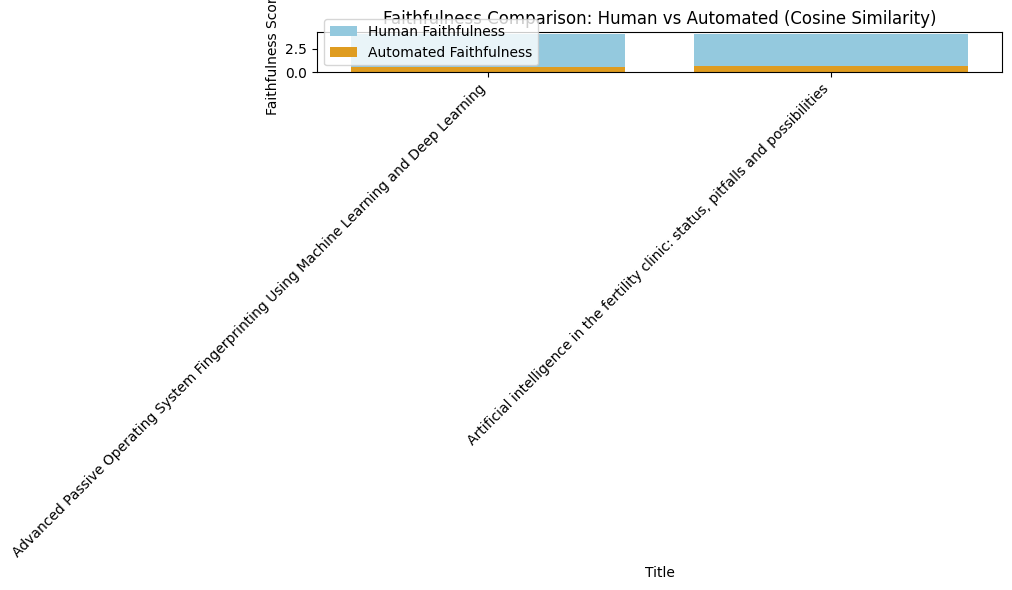

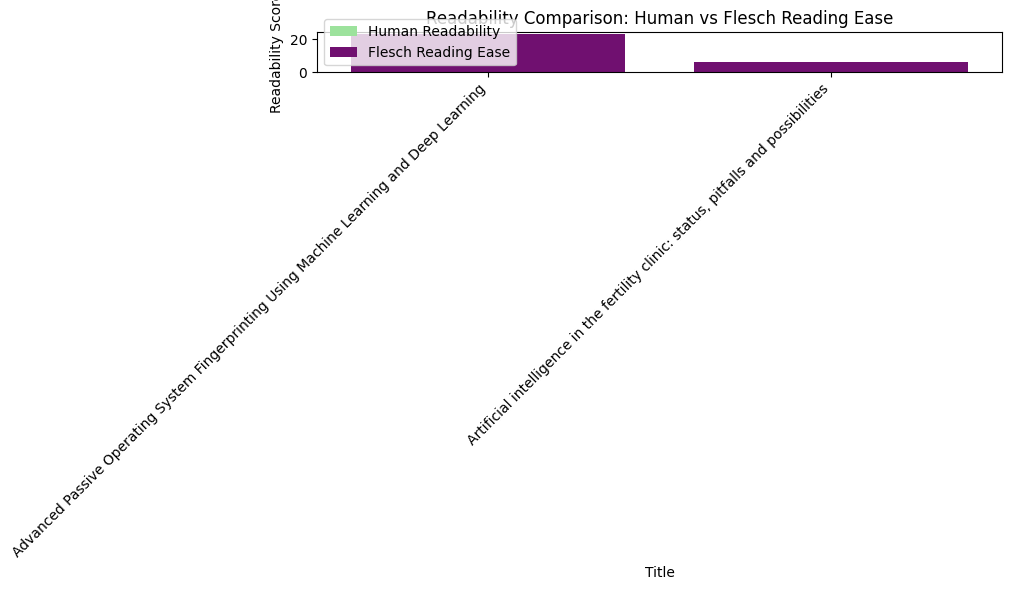

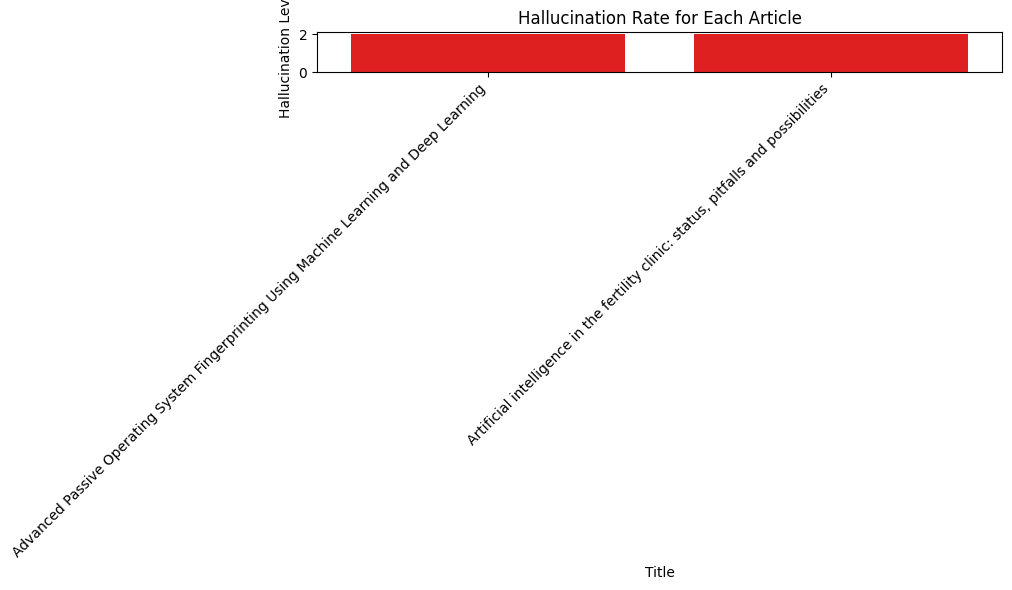

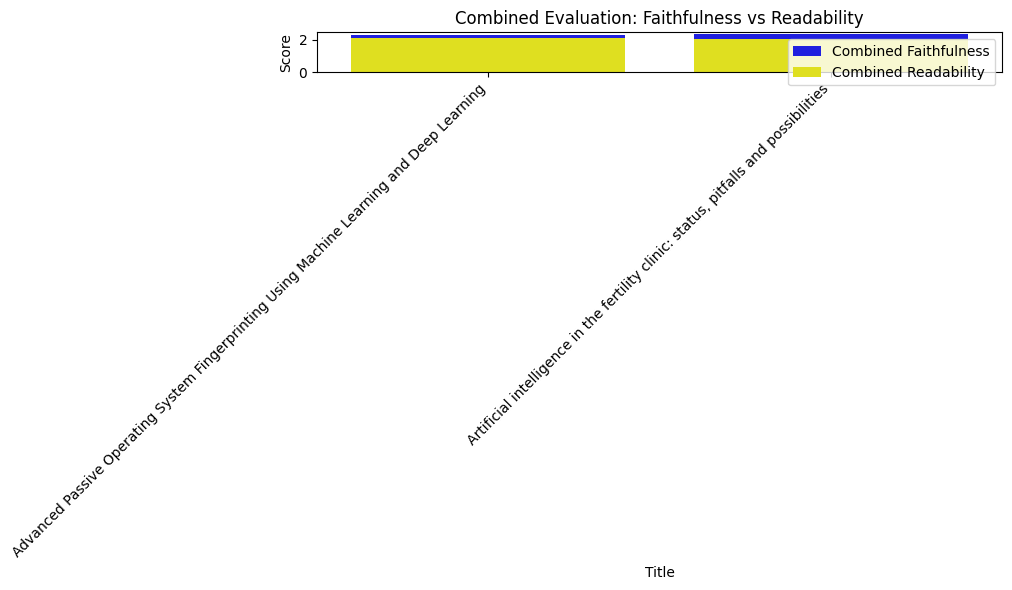

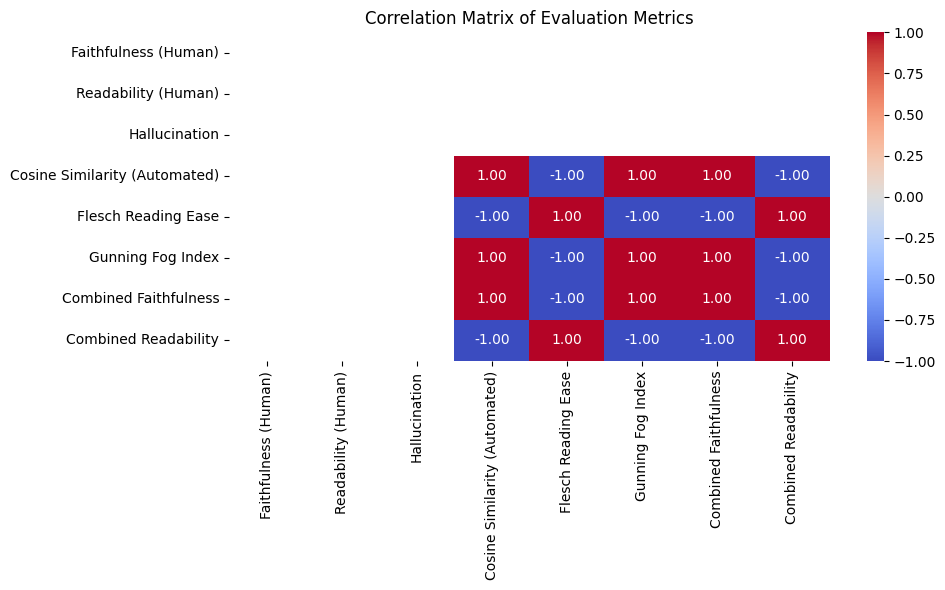

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have a DataFrame `df_evaluations` with columns like:
# 'Title', 'Faithfulness (Human)', 'Readability (Human)', 'Hallucination',
# 'Cosine Similarity (Automated)', 'Flesch Reading Ease', 'Gunning Fog Index'

# Create a DataFrame from evaluation results for only the first two articles
evaluation_results_list = []
for article_id in range(2):  # Only loop through the first two articles
    evaluation_results = human_evaluation_interface(article_id, df, retriever, qa_chain2, model)
    combined_results = combine_evaluations(evaluation_results)

    evaluation_results_list.append({
        "Title": df.iloc[article_id]["title"],
        "Faithfulness (Human)": evaluation_results["Faithfulness (Human)"],
        "Readability (Human)": evaluation_results["Readability (Human)"],
        "Hallucination": evaluation_results["Hallucination"],
        "Cosine Similarity (Automated)": evaluation_results["Faithfulness (Cosine Similarity)"],
        "Flesch Reading Ease": evaluation_results["Flesch Reading Ease"],
        "Gunning Fog Index": evaluation_results["Gunning Fog Index"],
        "Combined Faithfulness": combined_results["Combined Faithfulness"],
        "Combined Readability": combined_results["Combined Readability"]
    })

df_evaluations = pd.DataFrame(evaluation_results_list)

# Visualization 1: Comparison of Faithfulness (Human) vs. Automated (Cosine Similarity)
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Faithfulness (Human)", data=df_evaluations, color='skyblue', label="Human Faithfulness")
sns.barplot(x="Title", y="Cosine Similarity (Automated)", data=df_evaluations, color='orange', label="Automated Faithfulness")
plt.xticks(rotation=45, ha="right")
plt.title('Faithfulness Comparison: Human vs Automated (Cosine Similarity)')
plt.ylabel('Faithfulness Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 2: Readability Scores (Flesch Reading Ease vs. Human Readability)
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Readability (Human)", data=df_evaluations, color='lightgreen', label="Human Readability")
sns.barplot(x="Title", y="Flesch Reading Ease", data=df_evaluations, color='purple', label="Flesch Reading Ease")
plt.xticks(rotation=45, ha="right")
plt.title('Readability Comparison: Human vs Flesch Reading Ease')
plt.ylabel('Readability Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 3: Hallucination Rate for Each Article
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Hallucination", data=df_evaluations, color='red')
plt.xticks(rotation=45, ha="right")
plt.title('Hallucination Rate for Each Article')
plt.ylabel('Hallucination Level')
plt.tight_layout()
plt.show()

# Visualization 4: Combined Faithfulness vs Combined Readability
plt.figure(figsize=(10, 6))
sns.barplot(x="Title", y="Combined Faithfulness", data=df_evaluations, color='blue', label="Combined Faithfulness")
sns.barplot(x="Title", y="Combined Readability", data=df_evaluations, color='yellow', label="Combined Readability")
plt.xticks(rotation=45, ha="right")
plt.title('Combined Evaluation: Faithfulness vs Readability')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 5: Heatmap of Correlations Between Evaluation Metrics
plt.figure(figsize=(10, 6))
correlation_matrix = df_evaluations[[
    "Faithfulness (Human)", "Readability (Human)", "Hallucination",
    "Cosine Similarity (Automated)", "Flesch Reading Ease", "Gunning Fog Index",
    "Combined Faithfulness", "Combined Readability"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Example evaluation results
evaluation_results = [
    {
        "Article ID": 15,
        "Faithfulness (Human)": 4,
        "Readability (Human)": 4,
        "Hallucination": 2,
        "Faithfulness (Cosine Similarity)": 0.89,
        "Flesch Reading Ease": 19.87,
        "Gunning Fog Index": 17.29
    },
    # Add more dictionaries for other articles as needed
]

# Convert to a pandas DataFrame for easy visualization
df_results = pd.DataFrame(evaluation_results)

# Print the table
print(df_results.to_string(index=False))


 Article ID  Faithfulness (Human)  Readability (Human)  Hallucination  Faithfulness (Cosine Similarity)  Flesch Reading Ease  Gunning Fog Index
         15                     4                    4              2                              0.89                19.87              17.29


In [ ]:
# ROUGE to see if terms mentioned in query is present in answer
# trick questions

## Vizualisation

In [ ]:
# load embeddings from Chroma
embeddings = vectorstore._collection.get(include=['embeddings'])['embeddings']
document_embeddings = np.array(embeddings)

# reduce dimensions with PCA to speed up TSNE and UMAP
pca = PCA(n_components=50)
pca_embeddings = pca.fit_transform(document_embeddings)

In [ ]:
# apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

# apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(pca_embeddings)

# apply KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels_tsne = kmeans.fit_predict(tsne_embeddings)
cluster_labels_umap = kmeans.fit_predict(umap_embeddings)

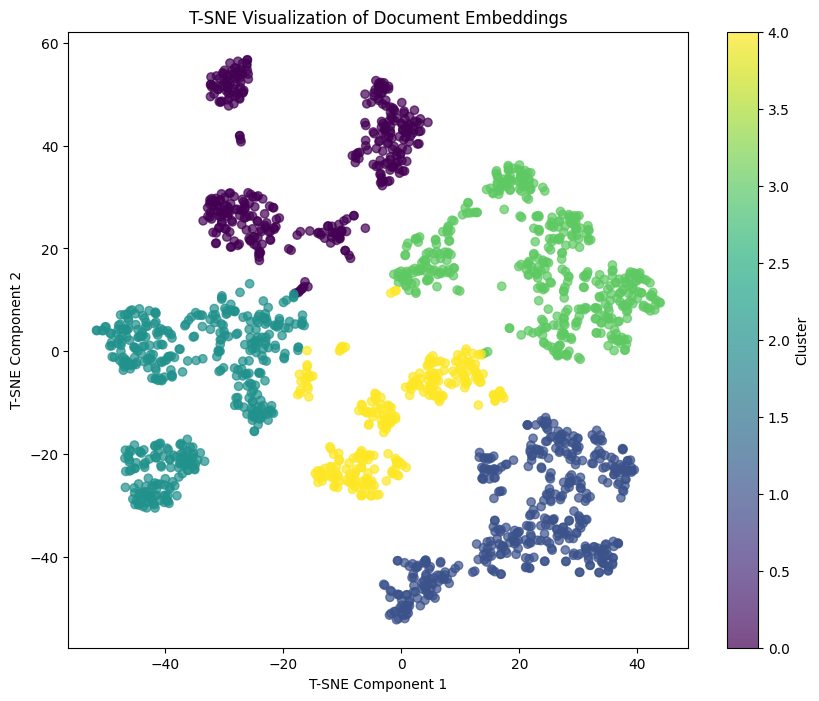

In [ ]:
# plot T-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels_tsne, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("T-SNE Visualization of Document Embeddings")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.show()

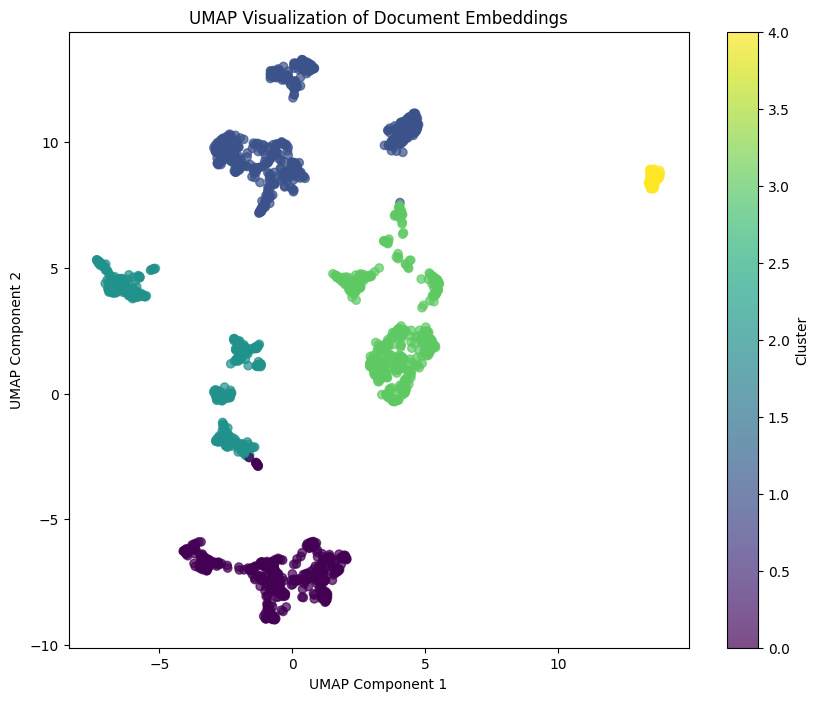

In [ ]:
# plot UMAP
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels_umap, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("UMAP Visualization of Document Embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [ ]:
# load document texts
documents = vectorstore._collection.get(include=['documents'])['documents']

# convert text to document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=5)
dtm = vectorizer.fit_transform(documents)

# train LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# print top words for each topic
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Topic 1: used, sperm, deep, ded, ai, model, learning, images, al, et
Topic 2: use, different, learning, language, models, model, rule, ai, journalism, data
Topic 3: random, space, algorithm, function, value, number, state, fig, matrix, ca
Topic 4: algorithm, results, variant, using, learning, based, os, time, la, tcp
Topic 5: 20, university, networks, doi, 12, network, 10, ieee, pp, vol


In [ ]:
# extract text documents
documents = vectorstore._collection.get(include=['documents'])['documents']

# initialize BERTopic
topic_model = BERTopic()

# fit the model
topics, probs = topic_model.fit_transform(documents)

# get the top topics
topic_model.get_topic_info()

# vizualise chart
topic_model.visualize_barchart(top_n_topics=5)